<a href="https://www.kaggle.com/code/edrickkesuma/in-depth-power-averaging-0-81848?scriptVersionId=91095775" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

## In-depth Power Averaging - TPS Sept 2021

Hello, this should be the proper way to do power averaging after much experimentation. My previous [notebook](https://www.kaggle.com/edrickkesuma/power-averaging-is-your-friend) did not consider many nuances with power averaging. 

This notebook will explain in much more detail:
* What power to use
* How to deal with clustered models (clusters of different correlations)
* How to keep improving your score

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

## Read in submission files

In [2]:
# Stack submissions
# 0.81826 - Stack1 from https://www.kaggle.com/vishwas21/tps-sep-21-3-level-custom-stacking
stack1_sub = pd.read_csv('../input/tps-sep-21-3-level-custom-stacking/submission.csv')
# 0.81846 - Stack2 from https://www.kaggle.com/mlanhenke/tps-09-simple-blend-stacking-xgb-lgbm-catb
stack2_sub = pd.read_csv('../input/tps-09-simple-basic-stacking-lgbm-catb-xgb/stacked_submission.csv')
# 0.81845 - Stack3 from https://www.kaggle.com/mlanhenke/tps-09-simple-blend-stacking-xgb-lgbm-catb/data
stack3_sub = pd.read_csv('../input/tps-09-simple-blend-stacking-xgb-lgbm-catb/stacked_submission.csv')
# 0.81845 - Stack4 from https://www.kaggle.com/aayush26/tps-sep-2021-simple-weighted-ensemble
stack4_sub = pd.read_csv('../input/tps-sep-2021-simple-weighted-ensemble/submission_weighted_ensemble_1.csv')

# Catboost submissions
# 0.81789 - Catboost from https://www.kaggle.com/jonigooner/catboost-classifier
cb_sub = pd.read_csv('../input/catboost-classifier/catboost_classifier.csv')

# LGBM submissions
# 0.81814 - LGBM from https://www.kaggle.com/realtimshady/single-simple-lightgbm
lgbm1_sub = pd.read_csv('../input/lgbm-submission/submission.csv')
# 0.81835 - LGBM from https://www.kaggle.com/ivankontic/004-2o-lightgbm-colsample-tps-sep-2021/data
lgbm2_sub = pd.read_csv('../input/004-2o-lightgbm-colsample-tps-sep-2021/submission.csv')
# 0.81837 - https://www.kaggle.com/martynovandrey/one-model-voting-from-0-81800-to-0-81837
lgbm3_sub = pd.read_csv('../input/one-model-voting-from-0-81800-to-0-81837/submission.csv')
# 0.81830s - forked from low colsample LGBM
lgbm4_sub = pd.read_csv('../input/additional-runs-low-colsample-lgbm/submission.csv')
lgbm5_sub = pd.read_csv('../input/additional-runs-low-colsample-lgbm/submission (1).csv')

# XGB submissions
# Around 0.8175s - personal submissions
xgb1_sub = pd.read_csv('../input/xgboost-submission-files-for-tps-september/TPS Sept Submission')
xgb2_sub = pd.read_csv('../input/xgboost-submission-files-for-tps-september/TPS Sept Submission (1)')
xgb3_sub = pd.read_csv('../input/xgboost-submission-files-for-tps-september/TPS Sept Submission (2)')
xgb4_sub = pd.read_csv('../input/xgboost-submission-files-for-tps-september/TPS Sept Submission (3)')

## Visualize correlations

In [3]:
list_of_subs = [stack1_sub.claim, stack2_sub.claim, stack3_sub.claim, stack4_sub.claim, cb_sub.claim, 
                lgbm1_sub.claim,lgbm2_sub.claim, lgbm3_sub.claim, lgbm4_sub.claim, lgbm5_sub.claim,
                xgb1_sub.claim, xgb2_sub.claim, xgb3_sub.claim, xgb4_sub.claim]

In [4]:
group_labels = ['stack1', 'stack2', 'stack3', 'stack4', 'catboost', 'lgbm1', 'lgbm2', 'lgbm3', 'lgbm4', 'lgbm5', 'xgb1', 'xgb2', 'xgb3', 'xgb4']

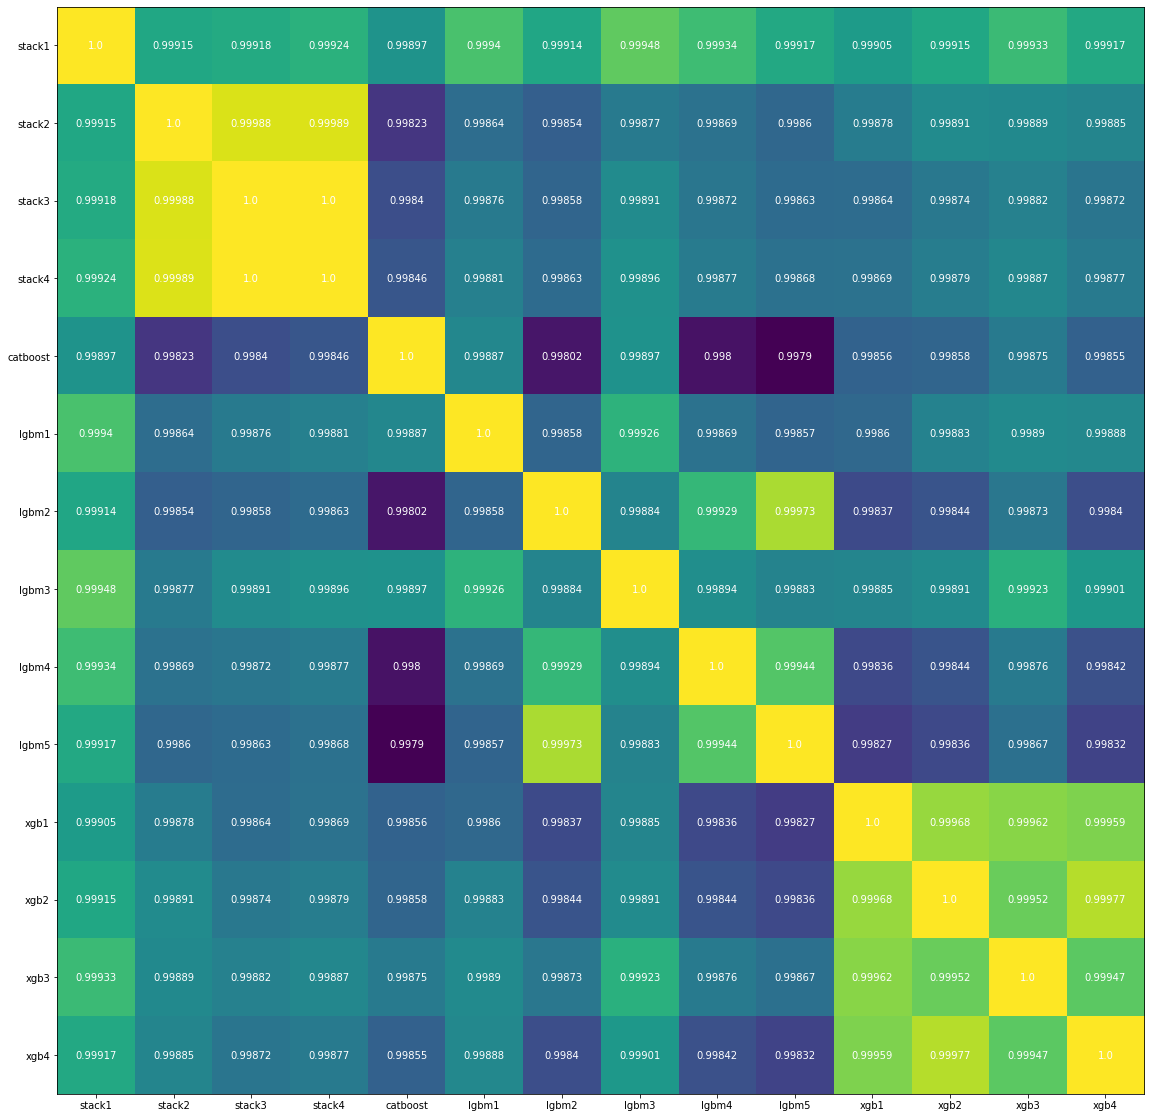

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

data = np.corrcoef(list_of_subs)

fig, ax = plt.subplots(figsize=(20,20))
im = ax.imshow(data)

ax.set_xticks(np.arange(len(group_labels)))
ax.set_yticks(np.arange(len(group_labels)))

ax.set_xticklabels(group_labels)
ax.set_yticklabels(group_labels)

for i in range(len(group_labels)):
    for j in range(len(group_labels)):
        text = ax.text(j, i, data[i, j].round(5),
                       ha="center", va="center", color="w")

# 1. Finding a power

## Correlation jumping

First, we have to do what I like to call ***correlation jumping***

Here's how:
1. First, find the strongest submission. stack2_sub has a 0.81846 score so we use that.
2. Next, we find the submission that has the highest correlation with stack2_sub. That would be stack4_sub with a correlation of 0.99989.
3. Remove stack2_sub from the correlation matrix.
4. Now use stack4_sub and find the submission which has the highest correlation with stack4_sub. That would be stack3_sub with a correlation of 1.0.
5. Remove stack4_sub from the correlation matrix
6. Repeat this process until you've removed all submissions

For this example, correlation jumping would go like this:

stack2 - stack4 - stack3 - stack1 - lgbm3 - lgbm1 - xgb4 - xgb2 - xgb3 - xgb5 - cb - lgbm2 - lgbm5 - lgbm4

## Finding a threshold power

Based on correlation jumping, you want to get the correlation between:

**the submission at the beginning (stack2) and the submission at the end (lgbm4)**

Which is 0.99869

Based on this, we use trial and error to find the power value where 0.99869^power = 0.9

It would go like this:
* 0.99869^1 = 0.99869
* 0.99869^2 = 0.99738
* ...
* 0.99869^80 = 0.9004
* 0.99869^81 = 0.8992

The threshold power here would be **80**

# 2. Dealing with clustered submissions / Ensembling

Friendly reminder: 

The power averaging formula is **Final Submission = (Submission1^Power + Submission2^Power + Submission3^Power + Submission4^Power) / 4**

Clustered submissions refer to groups where correlations are high between submissions (you can somewhat see by groups of color).

For example: xgb1, xgb2, xgb3, xgb4 have a small light yellow box (high correlation with each other).

You take them as cluster1

Another example: stack2, stack3, stack4 also have a light yellow box 

You take them as cluster2

After you've grouped all the submissions into clusters, you do the following
1. Power averaging in each cluster
2. Divide by the number of submissions in that cluster
3. Add them all up 
4. Divide by total number of clusters

Here's the clustered formula: **( (cluster1)/n_in_cluster1 + (cluster2)/n_in_cluster2 + (cluster3)/n_in_cluster3) ) / n_of_clusters**

In [6]:
ensemble = stack1_sub.copy()
power = 80
ensemble.loc[:,'claim'] =((stack1_sub**power + lgbm1_sub**power + lgbm3_sub**power + lgbm4_sub**power + lgbm5_sub**power )/5 
                          + (stack2_sub**power+ stack3_sub**power + stack4_sub**power)/3 
                          + (cb_sub**power + lgbm2_sub**power)/2 
                          + (xgb1_sub**power + xgb2_sub**power + xgb3_sub**power + xgb4_sub**power)/4 
                         )/4

In [7]:
ensemble

,id,claim
0,957919,3.502297e-21
1,957920,7.773428e-73
2,957921,9.122972e-17
3,957922,2.132380e-71
4,957923,1.769987e-64
...,...,...
493469,1451388,2.517808e-07
493470,1451389,8.626115e-75
493471,1451390,3.900374e-10
493472,1451391,8.358590e-69


In [8]:
ensemble.to_csv('submission.csv', index=False)

# 3. How to keep improving your score

After you've done all this, it can still be better.

These are the two things I've been doing to improve the blend:
1. **Trying different powers** - Shift the power up and down from the threshold by 5 or 10. Sometimes it gives a 0.00001 improvement (which can increase your rank by some 50 places).
2. **Adding more submissions** - The more the merrier! I added 2 submissions and got an overall increase of 0.00004. This should probably be what you're looking for to push the ranks as much as you can!